# Prototypical Networks
### on the Omniglot Dataset

In [1]:
import numpy as np
import os
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torchvision

## Load Dataset

In [2]:
def load_characters(root, alphabet):
    '''
    Loads the characters from a given alphabet
    Args:
        root (str): Root directory
        alphabet (str): folder name of alphabet
    Returns:
        (tuple) of:
            (list): images
            (list): labels
    '''
    X = []
    y = []
    
    alphabet_path = os.path.join(root, alphabet)
    characters = os.listdir(alphabet_path)
    
    for char in characters:
        char_path = os.path.join(alphabet_path, char)
        images = os.listdir(char_path)
        
        for img in images:
            image = cv2.imread(os.path.join(char_path, img))
            image = cv2.resize(image, (28, 28)) / 255
            X.append(image)
            y.append(f'{alphabet}_{char}')
    
    return X, y

In [3]:
def load_data(root):
    '''
    Loads the full omniglot dataset from a root directory
    Args:
        root (str): path of omniglot dataset
    Returns:
        (tuple) of:
            (ndarray): images
            (ndarray): labels
    '''
    X_data = []
    y_data = []
    
    alphabets = os.listdir(root)
    for alphabet in tqdm(alphabets):
        X, y = load_characters(root, alphabet)
        X_data.extend(X)
        y_data.extend(y)
    
    return np.array(X_data), np.array(y_data)

In [4]:
X_train, y_train = load_data('omniglot/images_background/')

## Task Generation

In [40]:
def extract_sample(X_data, y_data, k_shot=5, n_way=5, n_query=5):
    '''
    Extract a random sample as a k-shot n-way task
    Args:
        k_shot (int): number of images per class
        n_way (int): number of classes in the task
        n_query (int): number of query images
        X_data (ndarray): images
        y_data (ndarray): labels
    Returns:
        (ndarray): sampled images of shape (n_way, k_shot + n_query, 28, 28, 3)
    '''
    sample = []
    # Randomly select 5 classes
    sampled_cls = np.random.choice(np.unique(y_data), n_way, replace=False)
    
    for c in sampled_cls:
        # Select images belonging to that class
        X_data_c = X_data[y_data == c]
        
        # Sample k_shot+n_query images
        sample_images = np.random.permutation(X_data_c)[:(k_shot+n_query)]
        sample.append(sample_images)

    sample = np.array(sample)
    # Convert to tensor and permute the images as channels first
    sample = torch.from_numpy(sample).float().permute(0, 1, 4, 2, 3)
    
    return sample

In [41]:
def display_sample(sample):
    '''Display the samples of the task as a grid'''
    # Reshape to 4-dimensions from 5-dimensions
    sample_4d = sample.view(sample.shape[0]*sample.shape[1], *sample.shape[2:])
    
    # Make a grid
    out = torchvision.utils.make_grid(sample_4d, nrow=sample.shape[1])
    
    plt.figure(figsize = (16,7))
    plt.imshow(out.permute(1, 2, 0))

In [59]:
test_sample = extract_sample(X_train, y_train, k_shot=5, n_way=8, n_query=5)

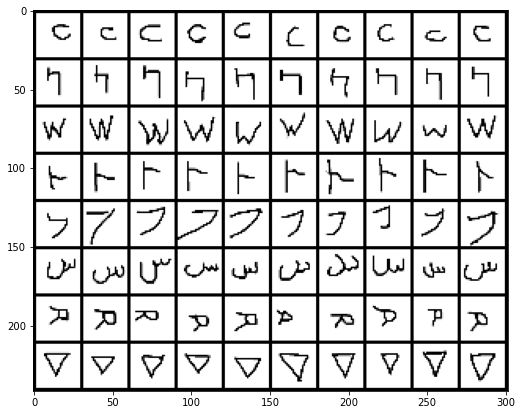

In [60]:
display_sample(test_sample)

## Model

In [61]:
class Image2Vector(nn.Module):
    def __init__(self):
        super(Image2Vector, self).__init__()
        
        self.input_block = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2))
        
        self.conv_block = nn.Sequential(nn.Conv2d(64, 64, 3, padding=1),
                                        nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.MaxPool2d(2))
    def forward(self, x):
        
        x = self.input_block(x)
        x = self.conv_block(x)
        x = self.conv_block(x)
        x = self.conv_block(x)
        
        out = x.view(x.size(0), -1)
        return out        

In [62]:
class ProtoNet(nn.Module):
    '''ProtoNet Model for usage with known/labelled data'''
    def __init__(self):
        super(ProtoNet, self).__init__()
        
        self.encoder = Image2Vector()
    
    def forward(self, sample, k_shot, n_way, n_query, device):
        '''Forward pass
        Args:
            sample (torch.Tensor): sample of shape (n_way, k_shot + n_query, 28, 28, 3)
            k_shot (int): number of images per class
            n_way (int): number of classes
            n_query (int): number of query images per class
        
        Returns:
            tuple of:
                loss, dict of loss value, accuracy, predictions
        '''
        # Get the support set and query set images
        support = sample[:, :k_shot]
        queries = sample[:, k_shot:]
        
        # Get the target indices
        targets = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long().to(device)
        
        # Concatenate support set and query set along the 0th dimension
        x = torch.cat([support.contiguous().view(n_way * k_shot, *support.size()[2:]), 
                       queries.contiguous().view(n_way * n_query, *queries.size()[2:])], 0)
        
        # Get the embeddings
        embeds = self.encoder(x)
        z_dim = embeds.size(-1)
        
        # Compute Prototypes
        protos = embeds[:n_way * k_shot].view(n_way, k_shot, z_dim).mean(1)
        
        # Get query embeddings
        query_embeds = embeds[n_way * k_shot:]
        
        # Compute Distances
        distances = self.euclidean(query_embeds, protos)
        
        # Compute Log Softmax over the inverse of euclidean distances
        log_p = F.log_softmax(-distances, dim=1).view(n_way, n_query, -1)
        
        # Compute the negative of log softmax for correct classes (NLL)
        neg_log_p = -log_p.gather(2, targets)
        
        # Calculate the mean NLL loss
        loss = neg_log_p.squeeze().view(-1).mean()
        
        # Get predictions and calculate accuracy
        y_hat = log_p.argmax(2)
        accuracy = torch.eq(y_hat, targets.squeeze()).float().mean()
        
        return loss, {'loss': loss.item(), 
                      'preds': y_hat, 
                      'acc': accuracy.item()}
        
        
    def euclidean(self, queries, protos):
        '''
        Calculates Euclidean Distances between queries and prototypes
        Args:
            queries (torch.Tensor): shape (n, d) where n is n_way*n_query
            protos (torch.Tensor): shape (m, d) where m is n_way
        Returns:
            (torch.Tensor): shape (n, m) i.e. for each query the euclidean distances
                            to each of the prototypes
        '''
        n = queries.size(0)
        m = protos.size(0)
        d = queries.size(1)
        assert queries.size(1) == protos.size(1), 'Vector Dimension of Query and Prototypes are not same'
        
        # Reshaping the queries and prototypes for distance calculation
        queries = queries.unsqueeze(1).expand(n, m, d)
        protos = protos.unsqueeze(0).expand(n, m, d)
        
        distance = torch.pow(queries - protos, 2).sum(2) # of shape n x m
        
        return distance

### Under the Hood Working of ProtoNet Class
The coming code cells are just a line by line expansion of ProtoNet Class

In [63]:
k_shot = 5
n_way = 8
n_query = 5

Create Encoder

In [64]:
# Create our encoder
img2vec = Image2Vector()

In [65]:
# Test on sample image
img2vec(test_sample[0][:1]).shape # a vector of size 64

torch.Size([1, 64])

Get Support and Query Sets

In [66]:
# Get support set and query set
support = test_sample[:, :k_shot]
queries = test_sample[:, k_shot:]

In [67]:
print('Support Set shape', support.shape)
print('Query Set shape', queries.shape)

Support Set shape torch.Size([8, 5, 3, 28, 28])
Query Set shape torch.Size([8, 5, 3, 28, 28])


In [68]:
# Get the target indices
targets = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
targets

tensor([[[0],
         [0],
         [0],
         [0],
         [0]],

        [[1],
         [1],
         [1],
         [1],
         [1]],

        [[2],
         [2],
         [2],
         [2],
         [2]],

        [[3],
         [3],
         [3],
         [3],
         [3]],

        [[4],
         [4],
         [4],
         [4],
         [4]],

        [[5],
         [5],
         [5],
         [5],
         [5]],

        [[6],
         [6],
         [6],
         [6],
         [6]],

        [[7],
         [7],
         [7],
         [7],
         [7]]])

Compute Embeddings

In [69]:
support.contiguous().view(n_way * k_shot, *support.size()[2:]).shape

torch.Size([40, 3, 28, 28])

In [70]:
queries.contiguous().view(n_way * n_query, *queries.size()[2:]).shape

torch.Size([40, 3, 28, 28])

In [71]:
# Concatenate our support set and query set one after the other for getting embeddings
x = torch.cat([support.contiguous().view(n_way * k_shot, *support.size()[2:]), 
               queries.contiguous().view(n_way * n_query, *queries.size()[2:])], 0)
x.shape

torch.Size([80, 3, 28, 28])

In [72]:
# Compute the embeddings
embeds = img2vec(x)
embeds

tensor([[1.1022, 1.0267, 0.0000,  ..., 1.9926, 0.8580, 1.5610],
        [1.4013, 1.3212, 0.0000,  ..., 1.9195, 0.3236, 1.0642],
        [1.9859, 1.7589, 0.4227,  ..., 1.6304, 0.4057, 0.7178],
        ...,
        [1.6505, 0.6739, 0.2579,  ..., 2.7312, 1.0457, 2.1168],
        [1.2668, 1.2517, 0.5820,  ..., 2.4464, 0.9450, 1.8159],
        [1.2381, 1.8705, 0.6152,  ..., 2.3050, 0.2815, 1.6858]],
       grad_fn=<ViewBackward>)

In [73]:
embeds.shape

torch.Size([80, 64])

In [76]:
d = embeds.size(1) # 64

In [77]:
# Compute prototypes
protos = embeds[:n_way * k_shot].view(n_way, k_shot, d).mean(1)
protos

tensor([[1.7727, 1.3799, 0.5694, 0.0743, 1.4523, 1.0944, 1.2883, 1.1580, 0.6611,
         1.4628, 1.4533, 0.5640, 0.6583, 0.8395, 1.5386, 0.5691, 0.5157, 0.9596,
         0.1853, 1.4846, 1.6200, 0.8320, 0.9223, 1.0406, 0.6368, 0.6653, 0.6552,
         0.6854, 1.7008, 1.1907, 0.6864, 0.8771, 1.1570, 1.6072, 1.2508, 0.2691,
         0.6782, 1.8596, 1.4605, 0.8178, 1.2031, 1.2806, 1.3902, 0.4347, 1.4645,
         1.1253, 1.2219, 1.1288, 1.2832, 0.2668, 2.0885, 0.6085, 0.9297, 1.0115,
         0.8789, 1.4217, 0.7443, 0.9702, 0.2754, 0.8390, 0.5878, 2.0385, 0.3413,
         1.1543],
        [1.0784, 0.9691, 0.7820, 0.4674, 1.6777, 1.1997, 1.5639, 0.8574, 1.1706,
         0.7531, 1.3660, 1.9734, 0.8744, 0.7091, 0.8725, 0.6674, 0.3232, 0.8829,
         0.2204, 1.4184, 1.2411, 1.2839, 1.5177, 1.2010, 0.5864, 0.9159, 0.6811,
         1.1865, 1.0510, 0.6907, 0.9775, 0.8436, 1.2261, 1.7077, 1.4403, 0.2419,
         1.2979, 1.3357, 1.2870, 0.7124, 0.8515, 0.9745, 1.1639, 0.0481, 1.3895,
         1

In [78]:
protos.shape

torch.Size([8, 64])

In [79]:
# Get query embeddings
query_embeds = embeds[n_way * k_shot:]
query_embeds

tensor([[1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564],
        [1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019],
        [1.8529, 2.3469, 0.2154,  ..., 2.0572, 0.0000, 0.9588],
        ...,
        [1.6505, 0.6739, 0.2579,  ..., 2.7312, 1.0457, 2.1168],
        [1.2668, 1.2517, 0.5820,  ..., 2.4464, 0.9450, 1.8159],
        [1.2381, 1.8705, 0.6152,  ..., 2.3050, 0.2815, 1.6858]],
       grad_fn=<SliceBackward>)

In [80]:
query_embeds.shape

torch.Size([40, 64])

Compute the euclidean distances

In [84]:
n = query_embeds.size(0) # 40
m = protos.size(0) # 8

In [86]:
queries_expanded = query_embeds.unsqueeze(1).expand(n, m, d)
queries_expanded # (40, 8, 64)

tensor([[[1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564],
         [1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564],
         [1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564],
         ...,
         [1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564],
         [1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564],
         [1.2122, 1.1866, 0.0000,  ..., 1.9737, 0.7022, 0.6564]],

        [[1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019],
         [1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019],
         [1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019],
         ...,
         [1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019],
         [1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019],
         [1.4856, 1.4043, 0.0000,  ..., 1.5301, 0.6007, 1.2019]],

        [[1.8529, 2.3469, 0.2154,  ..., 2.0572, 0.0000, 0.9588],
         [1.8529, 2.3469, 0.2154,  ..., 2.0572, 0.0000, 0.9588],
         [1.8529, 2.3469, 0.2154,  ..., 2.0572, 0.0000, 0.

In [88]:
protos_expanded = protos.unsqueeze(0).expand(n, m, d)
protos_expanded # (40, 8, 64)

tensor([[[1.7727, 1.3799, 0.5694,  ..., 2.0385, 0.3413, 1.1543],
         [1.0784, 0.9691, 0.7820,  ..., 1.3893, 0.8593, 1.4178],
         [1.6968, 1.8257, 0.5592,  ..., 2.0772, 0.6017, 0.9484],
         ...,
         [1.6577, 1.9079, 0.0718,  ..., 1.6684, 0.7734, 0.8812],
         [1.7184, 1.4968, 0.4418,  ..., 1.6350, 0.2475, 1.1718],
         [1.6773, 1.5626, 0.1909,  ..., 2.1264, 0.2666, 1.5977]],

        [[1.7727, 1.3799, 0.5694,  ..., 2.0385, 0.3413, 1.1543],
         [1.0784, 0.9691, 0.7820,  ..., 1.3893, 0.8593, 1.4178],
         [1.6968, 1.8257, 0.5592,  ..., 2.0772, 0.6017, 0.9484],
         ...,
         [1.6577, 1.9079, 0.0718,  ..., 1.6684, 0.7734, 0.8812],
         [1.7184, 1.4968, 0.4418,  ..., 1.6350, 0.2475, 1.1718],
         [1.6773, 1.5626, 0.1909,  ..., 2.1264, 0.2666, 1.5977]],

        [[1.7727, 1.3799, 0.5694,  ..., 2.0385, 0.3413, 1.1543],
         [1.0784, 0.9691, 0.7820,  ..., 1.3893, 0.8593, 1.4178],
         [1.6968, 1.8257, 0.5592,  ..., 2.0772, 0.6017, 0.

In [91]:
# Euclidean distance
distances = torch.pow(queries_expanded - protos_expanded, 2).sum(2) # of shape n x m
distances # (40, 8)

tensor([[19.6701, 21.5831, 28.9834, 17.5571, 22.7283, 16.8089, 16.8804, 29.9129],
        [13.6924, 15.9849, 25.2635, 23.9843, 20.6786, 18.6670, 13.5503, 23.0578],
        [13.5561, 22.2678, 20.8243, 17.5599, 25.2794, 17.9123, 16.6159, 22.7450],
        [24.6884, 24.3688, 30.1246, 20.4578, 23.1189, 20.3681, 19.2400, 36.1382],
        [19.7303, 23.5405, 26.4508, 25.6062, 32.3252, 30.5579, 22.6733, 20.8097],
        [20.8356, 17.2133, 35.0748, 26.2276, 29.4145, 28.0322, 20.7528, 28.3812],
        [25.5387, 21.7481, 23.5753, 19.8942, 30.1111, 30.3409, 27.3074, 21.8187],
        [14.7976, 13.0619, 23.5642, 20.8001, 20.9580, 25.4101, 16.7929, 21.9584],
        [25.6248, 14.7292, 28.8249, 21.6467, 26.5108, 30.8992, 24.1417, 28.1295],
        [15.5201, 11.6913, 29.4572, 19.7205, 24.4660, 26.4719, 16.4078, 23.9119],
        [14.5653, 16.3525, 10.9960, 22.5646, 18.1606, 13.7269, 12.7770, 13.6198],
        [24.1067, 25.8352, 12.4032, 33.4370, 25.0808, 24.5142, 22.6884, 20.0627],
        [31.7338

In [94]:
# Compute Log Softmax over the inverse of euclidean distances
log_p = F.log_softmax(-distances, dim=1).view(n_way, n_query, -1)
log_p

tensor([[[-3.7665e+00, -5.6795e+00, -1.3080e+01, -1.6534e+00, -6.8247e+00,
          -9.0523e-01, -9.7678e-01, -1.4009e+01],
         [-8.1611e-01, -3.1086e+00, -1.2387e+01, -1.1108e+01, -7.8023e+00,
          -5.7907e+00, -6.7400e-01, -1.0181e+01],
         [-7.5981e-02, -8.7877e+00, -7.3442e+00, -4.0798e+00, -1.1799e+01,
          -4.4322e+00, -3.1358e+00, -9.2649e+00],
         [-5.9494e+00, -5.6298e+00, -1.1386e+01, -1.7189e+00, -4.3800e+00,
          -1.6292e+00, -5.0104e-01, -1.7399e+01],
         [-3.4973e-01, -4.1599e+00, -7.0702e+00, -6.2256e+00, -1.2945e+01,
          -1.1177e+01, -3.2927e+00, -1.4291e+00]],

        [[-3.6767e+00, -5.4404e-02, -1.7916e+01, -9.0687e+00, -1.2256e+01,
          -1.0873e+01, -3.5939e+00, -1.1222e+01],
         [-5.9312e+00, -2.1406e+00, -3.9678e+00, -2.8665e-01, -1.0504e+01,
          -1.0733e+01, -7.6998e+00, -2.2112e+00],
         [-1.9190e+00, -1.8334e-01, -1.0686e+01, -7.9215e+00, -8.0794e+00,
          -1.2532e+01, -3.9144e+00, -9.0799e+00]

In [98]:
# Compute the negative of log softmax for correct classes (NLL)
neg_log_p = -log_p.gather(2, targets)
neg_log_p.squeeze() # (8, 5)

tensor([[3.7665e+00, 8.1611e-01, 7.5981e-02, 5.9494e+00, 3.4973e-01],
        [5.4404e-02, 2.1406e+00, 1.8334e-01, 1.0999e-03, 3.0543e-02],
        [2.9255e-01, 5.2391e-04, 5.4570e+00, 7.5018e+00, 5.3930e-02],
        [2.3968e-01, 1.6117e-03, 1.4679e+00, 2.0146e-05, 5.9623e+00],
        [3.1645e+00, 3.0292e+00, 6.7502e-03, 6.4816e-02, 2.9965e-01],
        [5.6436e-02, 1.8537e-03, 6.7365e-01, 7.7087e-01, 1.1913e-03],
        [4.6173e+00, 3.1534e-03, 8.0947e+00, 4.3642e-01, 2.0270e+00],
        [1.7862e-02, 1.9719e-02, 1.5069e-01, 1.0323e+00, 1.6014e-02]],
       grad_fn=<SqueezeBackward0>)

In [101]:
# Calculate the mean NLL loss
loss = neg_log_p.squeeze().view(-1).mean()
loss

tensor(1.4707, grad_fn=<MeanBackward0>)

In [102]:
# Get predictions and calculate accuracy
y_hat = log_p.argmax(2)
y_hat

tensor([[5, 6, 0, 6, 0],
        [1, 3, 1, 1, 1],
        [2, 2, 5, 5, 2],
        [3, 3, 1, 3, 6],
        [6, 6, 4, 4, 4],
        [5, 5, 5, 6, 5],
        [3, 6, 4, 6, 0],
        [7, 7, 7, 2, 7]])

In [104]:
targets.squeeze()

tensor([[0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7]])

In [ ]:
# Accuracy calculation
accuracy = torch.eq(y_hat, targets.squeeze()).float().mean()
accuracy